# Module 05: Advection Dominated Systems Assignment

## Overview and Requirements

___DISASTER!___ An earthquake has resulted in a partial meltdown of a nuclear reactor and the contamination of that reactor's cooling water tanks. The reactor automatically scrammed and the reactor hall was safe enough that the fuel rods were removed, but not before a significant leak of radioactive Cesium into the water stored in the tanks. Cs-137 is highly soluble in water and so the whole tank is effectively uniformly contaminated. What's worse, the earthquake also ruptured the cooling water tanks and contaminated water is now leaking into the aquifer. The location of the rupture is such that it is too dangerous to repair. 

Your job as a consultant is to conduct a "worst case" scenario modeling study in which the tank will continue to drain contaminated water into the aquifer at a constant rate of 0.05% of its volume per year. The aquifer is an unconfined aquifer that has a saturated hydraulic conductivity ($K_s$) of 15.0 cm/day and a constant regional head gradient $\partial h/\partial t$ of 30.0 ft/mile. 

Using your trusy advection-dominated code your wrote as a graduate student at Boise State, you know you can simply modify the boundary conditions to your model to examine the impact. Your solution notebook you turn in should have code that produces the following plots:

* The concentration of the contaminant of the aquifer at the contamination site 
* Concentration profiles (concentration vs. distance) at every 50th time step of the simulation 
* The plot showing the evolution of concentration as a function of both distance from the contamination site and time
* The breakthrough curve (concentration vs. time) at a location x = 1500 m

Answer the following questions:
* What time step did you have to select to get the Courant number as close to 1.0 as possible? 
* If you were to have to describe what was going to happen to the water quality at the town located 1.5 km from the contamination site, how would you describe in words how the water quality will behave in the future? 
* If concentrations below 0.05 GBq/g are considered safe for drinking water quallity, at the town 1.5 km away from the contamination site, how many years in the future will it take the contamination plume to arrive? And how long will the water be unusable? 


### 1. Initial Setup and Creating the Domain

In [12]:
import numpy as np
import matplotlib.pyplot as plt

dx = 5.0  # Spatial interval [m] - DON'T CHANGE
dt = 0  # Time step [yr]

# Fraction of initial tank volume lost each year [yr-1]
k_tank = 0.0005 

xmin = 0.0 # Origin: Contamination site
xmax = 4000.0 # Edge of the domain

t0 = 0.0 # Time that the tank broke
tf = 10000.0 # End of simulation time

Ks = 15.0 # Saturated hydraylic conductivity [cm/day]
dhdx = 30.0 # Regional piezometric gradient [ft/mi]

Ks = Ks/100.0*365.25 # Converting Ks from [cm/day] to [m/yr]
dhdx = dhdx*(1/5280.0)

In [13]:
q = Ks*dhdx

print('The Darcy velocity is ' + '{:.3f}'.format(q) + ' [m/yr]')

The Darcy velocity is 0.311 [m/yr]


#### 1.1 Courant Number & Time Step Setup

In [14]:
Courant = q*(dt/dx)

print('The Courant number is ' + '{:.3f}'.format(Courant)+'. The optimal number is 1 to avoid numerical diffusion. Consider changing dt')

The Courant number is 0.000. The optimal number is 1 to avoid numerical diffusion. Consider changing dt


In [15]:
#dynamic determination for dt & stable courant number

while Courant < 1.00:
    dt = dt + 0.01
    Courant = q*(dt/dx)

#dt = dt - 0.01
print('The optimal time step is: dt = ' + str(dt))
print(Courant)

The optimal time step is: dt = 16.069999999999713
1.000494460227255


#### 1.2 Spatial Domain Setup

In [16]:
x = np.arange(xmin+dx/2, xmax, dx)
Nx = x.size

print('The number of cells is: Nx = ' + str(Nx))

The number of cells is: Nx = 800


#### 1.3 Time Vector Setup

In [17]:
t = np.arange(t0,tf+dt,dt)
Nt = t.size
print('The number of time steps: Nt = ' + str(Nt))

The number of time steps: Nt = 624


### 2. Setup Initial and Boundary Conditions

In [18]:
# Initial condition: concentration is 0 GBq/g everywhere except at x = 0, where it is 1 Bq/g
c0 = np.zeros((Nx,1))
c0[0] = 1

# Boundary condition: concentration decreases at a rate of k_tank [yr-1]
csource = c0[0]*np.exp(-k_tank*t)

#print(csource)

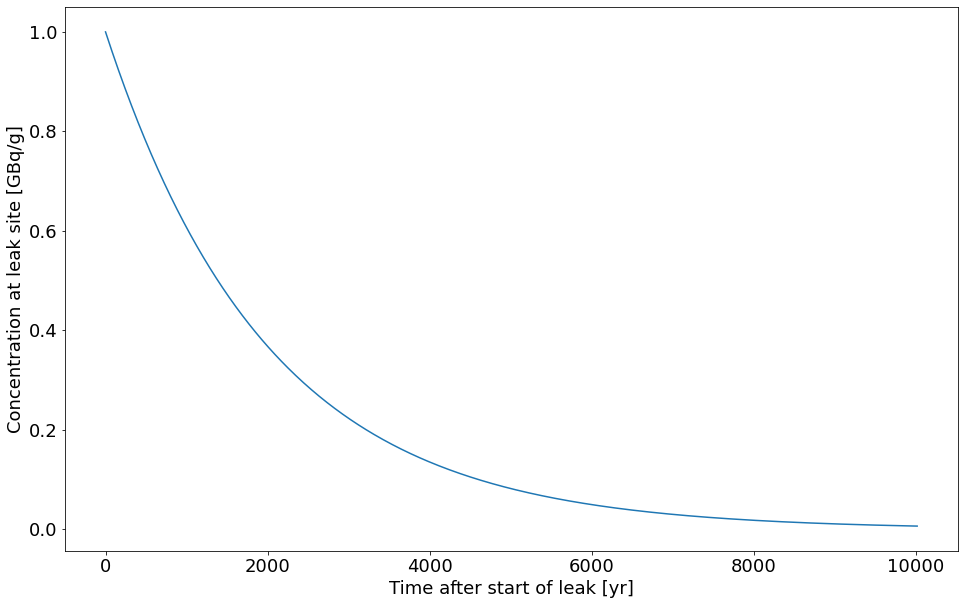

In [19]:
plt.figure(figsize=(16,10))
plt.rcParams.update({'font.size': 18})
plt.plot(t,csource)
plt.xlabel('Time after start of leak [yr]')
plt.ylabel('Concentration at leak site [GBq/g]')
plt.show()

### 3. Solution

#### 3.1 Preallocate Container for Solution

In [20]:
C = np.zeros((Nx,Nt))

#### 3.2 Compute Solution

In [21]:
for i in np.arange(Nt):
    
    # Get initial conditions
    if (i==0):
        Cprev = c0
    else:
        Cprev = C[:,i-1]
    
    Cnext = np.zeros((Nx))
    
    for j in np.arange(Nx):
        
        if (j==0):
            Cnext[0] = csource[i]
        else:
            Cnext[j] = Cprev[j] + q*(dt/dx)*(Cprev[j-1] - Cprev[j])
 
    C[:,i] = Cnext

### 4. Plots

#### 4.1 Concentration vs Distance @ Every 50th Time Step

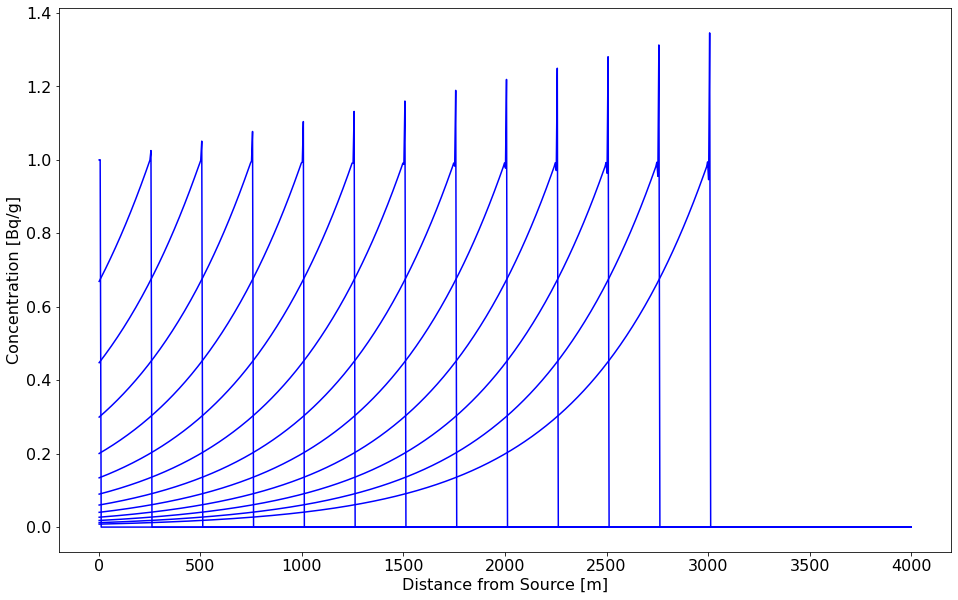

In [22]:
## First off, let's change the font size for all of our plots to be more legible
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(16,10))

for p in np.arange(0,Nt,50):
    plt.plot(x,C[:,p],'b')

plt.ylabel('Concentration [Bq/g]')
plt.xlabel('Distance from Source [m]')
plt.show()

#### 4.2 Meshgrid of Concentration vs Distance & Time

Text(0, 0.5, 'Time [years]')

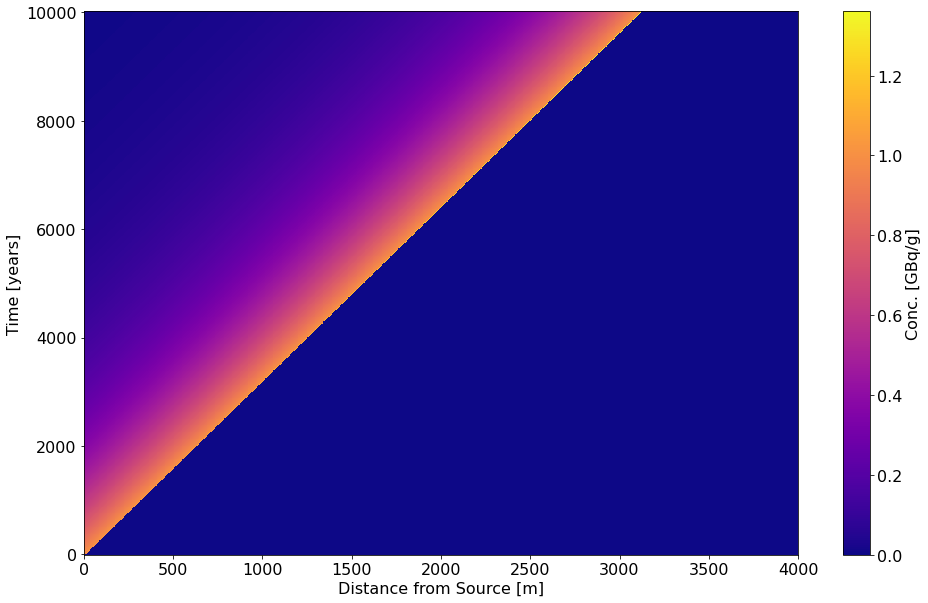

In [23]:
xx,tt = np.meshgrid(t,x)

plt.figure(figsize=(16,10))

plt.pcolormesh(tt,xx,C,shading='auto',cmap='plasma')

plt.colorbar(label='Conc. [GBq/g]')
plt.xlabel('Distance from Source [m]')
plt.ylabel('Time [years]')


#### 4.3 Breakthrough Curve at x = 1500 m

Text(0.5, 1.0, 'Breakthrough Curve @ x = 1500 m')

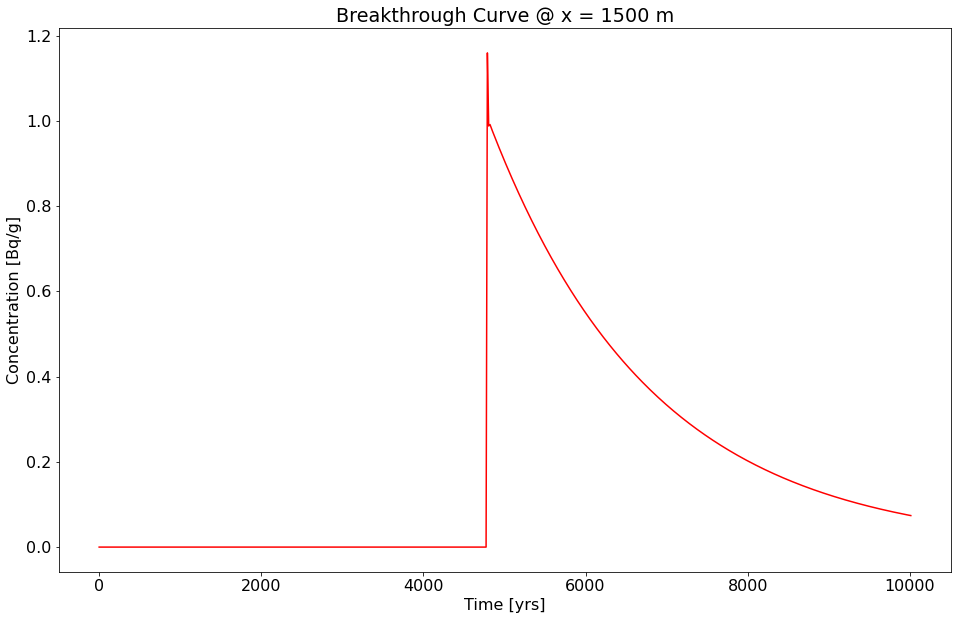

In [24]:
ind = (np.absolute(x-1500)).argmin()

plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(16,10))

plt.plot(t,C[ind,:],'r-')
plt.ylabel('Concentration [Bq/g]')
plt.xlabel('Time [yrs]')
plt.title('Breakthrough Curve @ x = 1500 m')

### 5. Questions

5.1 What time step did you have to select to get the Courant number as close to 1.0 as possible?
- I originally used a time step of 16.099 years. This gave me a courant number of 1.002, but my concentrations overtime became negative due to instability. To fix this I adjusted my while loop determining my dt to add increments of 0.01 instead of 0.1. This gave me a final time step of 16.069999999999713 which produced a courant number of 1.00049 and fixed my stability issues. 
5.2 If you were to have to describe what was going to happen to the water quality at the town located 1.5 km from the contamination site, how would you describe in words how the water quality will behave in the future?
- This scenario is shown above in the breakthrough curve at 1.5km. For about 4,900 years, the town's water quality would be left completely uncontaminated until the nuclear contamination hits all at once. After that the contamination decreases exponentionally and reaches 0.2 Bq/g right after 8,000 years. It appears to be reaching an asymptote of contamination of 0.05 Bq/g at 10,000 years.
5.3 If concentrations below 0.05 GBq/g are considered safe for drinking water quallity, at the town 1.5 km away from the contamination site, how many years in the future will it take the contamination plume to arrive? And how long will the water be unusable?
- As mentioned above, the town remains untouched for about 4,900 years. Once the contamination hits, the water is unusuable until 10,000 years after the breakout, so for a total of about 5,000 years.